[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mauro-moura/GA-023-Trabalho-Final/blob/main/03_quad_tree.ipynb)

In [1]:
import os

import glob
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from skimage.segmentation import (
    morphological_chan_vese,
    checkerboard_level_set,
)

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects

In [2]:
def keep_largest_connected_component(segmented_mask):
    """
    Keep only the largest connected component in a segmented binary mask.

    Parameters:
        segmented_mask (ndarray): Binary mask from segmentation (0s and 1s).
    
    Returns:
        ndarray: Binary mask with only the largest connected component.
    """
    labeled_mask = label(segmented_mask)
    
    largest_component = max(regionprops(labeled_mask), key=lambda r: r.area)
    
    largest_mask = (labeled_mask == largest_component.label).astype(np.uint8)
    return largest_mask

In [3]:
def quadtree(img, threshold=255, level=0, offset=(0, 0), level_set=None, min_size=4):
    if level_set is None:
        level_set = np.zeros_like(img, dtype=np.float32)
    
    if img.shape[0] != img.shape[1]:
        raise ValueError('Image must be square')
    
    if np.std(img) < threshold or img.shape[0] <= min_size:
        level_set[offset[0]:offset[0]+img.shape[0], offset[1]:offset[1]+img.shape[1]] = level
        return level_set
    else:
        h = img.shape[0] // 2
        quadtree(img[:h, :h], threshold, level + 1, (offset[0], offset[1]), level_set)
        quadtree(img[:h, h:], threshold, level + 1, (offset[0], offset[1] + h), level_set)
        quadtree(img[h:, :h], threshold, level + 1, (offset[0] + h, offset[1]), level_set)
        quadtree(img[h:, h:], threshold, level + 1, (offset[0] + h, offset[1] + h), level_set)
        return level_set

# def initialize_snake_mask_from_quadtree(level_set, target_levels):
#     """
#     Create an initial mask for the snake based on multiple levels of the quadtree.
    
#     Parameters:
#         level_set (ndarray): The level set image from the quadtree.
#         target_levels (list or tuple): The levels of the quadtree to use as the snake's initial region.
    
#     Returns:
#         ndarray: Binary mask for the snake initialization.
#     """
#     mask = np.isin(level_set, target_levels).astype(np.uint8)
#     return mask

def initialize_snake_mask_from_quadtree(level_set, max_level=2):
    """
    Create an initial binary mask for the snake based on quadtree levels up to a certain depth.
    
    Parameters:
        level_set (ndarray): The level set image from the quadtree.
        max_level (int): The maximum quadtree level to be considered as background (lower levels are typically the background).
    
    Returns:
        ndarray: Binary mask for the snake initialization, with 1 for foreground and 0 for background.
    """
    # Include all levels up to `max_level` as background (level <= max_level)
    mask = (level_set <= max_level).astype(np.uint8)
    return mask

def find_optimal_threshold(img, method="mean"):
    """
    Compute an optimal threshold for quadtree decomposition based on image variance.

    Parameters:
        img (ndarray): Input grayscale image.
        method (str): Method to compute the threshold ("mean", "median", "percentile").
                      - "mean": Use the mean standard deviation.
                      - "median": Use the median of standard deviations.
                      - "percentile": Use a specific percentile (e.g., 90th).

    Returns:
        float: Optimal threshold for quadtree decomposition.
    """
    block_std = []
    size = img.shape[0]
    for block_size in [2**i for i in range(int(np.log2(size)), 1, -1)]:
        for i in range(0, size, block_size):
            for j in range(0, size, block_size):
                block = img[i:i+block_size, j:j+block_size]
                if block.size > 1:
                    block_std.append(np.std(block))
    
    block_std = np.array(block_std)
    
    if method == "mean":
        return block_std.mean()
    elif method == "median":
        return np.median(block_std)
    elif method == "percentile":
        return np.percentile(block_std, 90)
    else:
        raise ValueError("Invalid method. Choose from 'mean', 'median', or 'percentile'.")

In [4]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

In [11]:
# Verify the binary images and check if the borders marked as 0 or 1, if not, correct it
def verify_binary_image(binary_image):
    if np.median(binary_image[0, :]) == 1:
        binary_image = 1 - binary_image
    return binary_image

In [5]:
def load_images(files, resize=(256,256)):
    images = []
    for file in files:
        im = Image.open(file)
        im = ImageOps.exif_transpose(im)
        if resize:
            im = im.resize(resize)
        im = im.convert('L')
        images.append(np.array(im))
    return np.array(images)

In [6]:
BASE_OUTPUT_PATH = 'outputs/segmentation_quad_tree'

In [7]:
mode = ['images', 'masks']
BASE_PATH_IMGS = os.path.join('data', mode[0])
BASE_PATH_MASKS = os.path.join('data', mode[1])
files = glob.glob(os.path.join(BASE_PATH_IMGS, '*'))
files_masks = glob.glob(os.path.join(BASE_PATH_MASKS, '*'))

In [8]:
images = load_images(files)

In [6]:
image = images[2]

print(image.shape)

(256, 256)


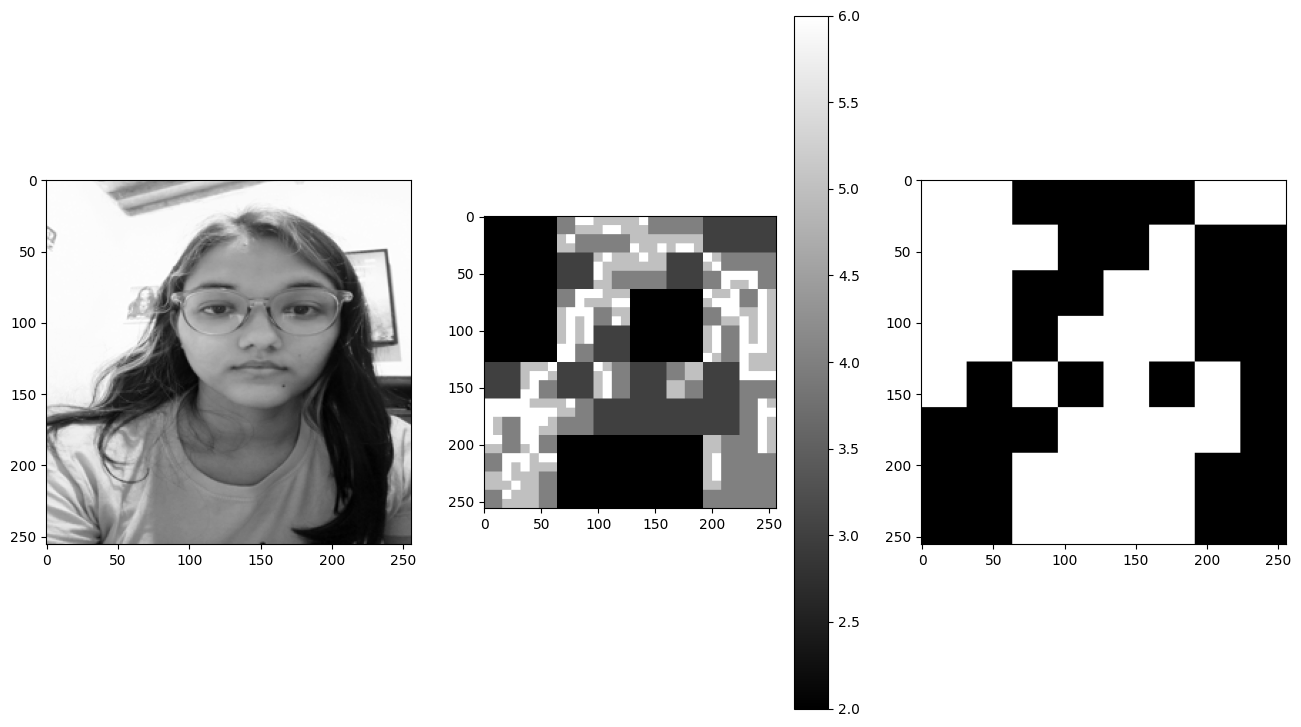

In [11]:
threshold = find_optimal_threshold(image, method="percentile")

qtree = quadtree(image, threshold=threshold)

plt.figure(figsize=(16,9))

plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(qtree, cmap='gray')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(initialize_snake_mask_from_quadtree(qtree, 3), cmap='gray')

plt.show()

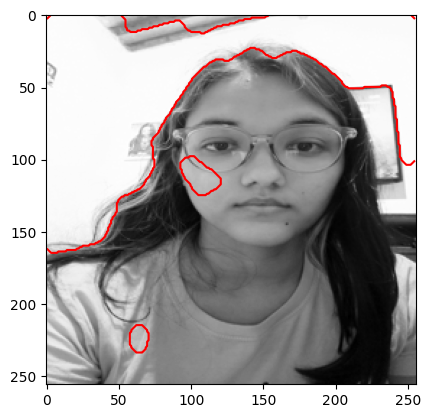

In [14]:
# image = images[0]
# init_ls = checkerboard_level_set(image.shape, 16)
init_ls = initialize_snake_mask_from_quadtree(qtree, 3)

evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 200, init_level_set=init_ls, smoothing=3, iter_callback=callback)

plt.imshow(image, cmap='gray')
plt.contour(evolution[-1], [0.5], colors='r')
plt.show()

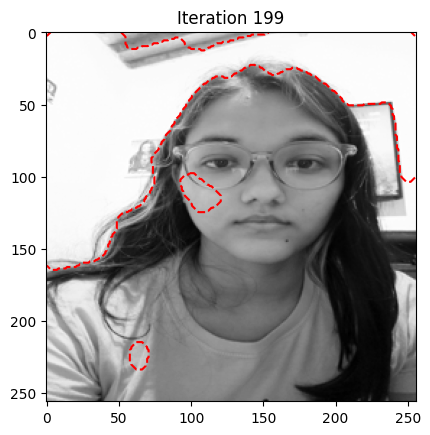

In [16]:
%matplotlib inline
from IPython.display import display, clear_output

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
# plt.ion()

for i in range(len(evolution)):
    ax.contour(evolution[i], [0.5], colors='r', linestyles='dashed')
    # plt.draw()
    clear_output(wait=True)
    display(fig)
    ax.set_title(f"Iteration {i}")
    plt.pause(0.01)
    for collection in ax.collections:
        collection.remove()

# plt.ioff()
plt.show()

/tmp/ipykernel_5662/1000026351.py:24: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  mask = remove_small_objects(mask, min_size=64, connectivity=1)


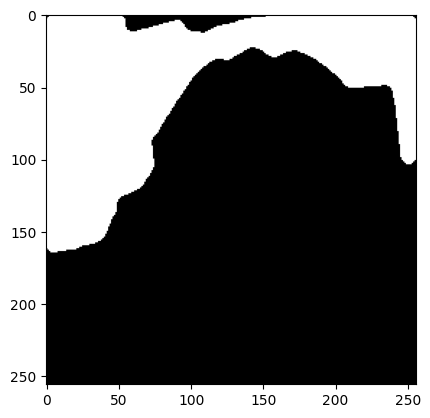

In [49]:
mask = remove_small_objects(ls, min_size=64, connectivity=1)
largest_snake_mask = keep_largest_connected_component(mask)
mask = np.zeros_like(image)
mask[largest_snake_mask > 0.5] = 1

plt.imshow(mask, cmap='gray')
# plt.contour(mask, [0.5], colors='r')
plt.show()

In [9]:
import time

from scipy.ndimage import gaussian_filter, binary_fill_holes
from skimage import morphology

def run_exp(resize, qtree_level_set=3, invert_qtree=False, debug=False):
    images = load_images(files, resize=resize)
    masks = load_images(files_masks, resize=resize)

    t1 = time.time()
    for i in range(len(images)):
            name = files[i].split('/')[-1][:-4]
            image = images[i]
            image = gaussian_filter(image, sigma=3)

            threshold = find_optimal_threshold(image, method="percentile")
            qtree = quadtree(image, threshold=threshold)
            init_ls = initialize_snake_mask_from_quadtree(qtree, qtree_level_set)
            if invert_qtree:
                init_ls = 1 - init_ls
            
            evolution = []
            callback = store_evolution_in(evolution)
            ls = morphological_chan_vese(image, 100, init_level_set=init_ls, smoothing=3, iter_callback=callback)

            mask = np.zeros_like(image)
            mask[evolution[-1] > 0.5] = 1
            mask = verify_binary_image(mask)
            mask = morphology.remove_small_objects(mask.astype('bool'), min_size=64, connectivity=1)
            mask = binary_fill_holes(mask).astype('uint8')
            mask = keep_largest_connected_component(mask)

            # Save mask
            mask = Image.fromarray(mask * 255)
            out_full_path = os.path.join(BASE_OUTPUT_PATH, f'{resize[0]}x{resize[1]}')
            if invert_qtree:
                out_full_path = os.path.join(BASE_OUTPUT_PATH + 'inverted', f'{resize[0]}x{resize[1]}')
            if not os.path.exists(out_full_path):
                os.makedirs(out_full_path)

            mask.save(os.path.join(out_full_path, f'{name}.png'))

            if debug:
                    plt.figure(figsize=(16, 9))
                    plt.subplot(2, 3, 1)
                    plt.imshow(image)
                    
                    plt.subplot(2, 3, 2)
                    plt.imshow(masks[i])
                    
                    plt.subplot(2,3,3)
                    plt.imshow(mask)

                    plt.show()
    t2 = time.time()

    print(f"Took {t2 - t1} seconds to process {len(images)} images.")

In [32]:
run_exp((256, 256))

Took 20.792027235031128 seconds to process 19 images.


In [33]:
run_exp((64, 64))

Took 2.2215323448181152 seconds to process 19 images.


In [34]:
run_exp((1024, 1024))

Took 320.74581241607666 seconds to process 19 images.


In [12]:
run_exp((256, 256), invert_qtree=True)

Took 19.403850555419922 seconds to process 19 images.
